## Birds 仿真实验

In [33]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import math
from numpy import loadtxt
import torch.utils.data as Data
from sklearn.metrics import mean_squared_error
import utils
from models.clstm import cLSTM, train_model_adam, regularize, ridge_regularize,arrange_input
import datetime
from Bird_pd_processing import *
from sklearn import preprocessing
import scipy.io as sio
print(torch.__version__)
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
%matplotlib

1.7.1
cuda:0
Using matplotlib backend: Qt5Agg


In [2]:
Birds_df = pd.read_csv("./鸟类数据集/Birds_tracking_data.csv", encoding = 'gbk')
Birds_ID = (list(set(Birds_df['终端'])))
Birds_ID.sort()
Birds_baieyan_ID = Birds_ID[0:7]
Birds_douyan_ID = Birds_ID[7:]

In [3]:
C_baieyan = []
for bird in Birds_baieyan_ID: 
    Birds = Birds_df.loc[Birds_df['终端'] == bird]
    c = Bird_Processing(Birds)
    C_baieyan.append(c)

C_douyan = []
for bird in Birds_douyan_ID: 
    Birds = Birds_df.loc[Birds_df['终端'] == bird]
    c = Bird_Processing(Birds)
    C_douyan.append(c)

for i in range(len(C_baieyan)):
    df = C_baieyan[i]
    missing_rate = ((df.isnull().sum())/df.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))
    print('第 ', i, '只白额雁', C_baieyan[i]['终端'][0] , '的数据缺失率为',missing_rate[0])

for i in range(len(C_douyan)):
    df = C_douyan[i]
    missing_rate = ((df.isnull().sum())/df.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))
    print('第 ', i, '只豆雁', C_douyan[i]['终端'][0] , '的数据缺失率为',missing_rate[0])




The time from  2017-12-30-00 to  2018-01-05-12
The time from  2017-12-30-00 to  2018-03-22-18
The time from  2017-12-30-00 to  2018-05-22-13
The time from  2017-12-30-00 to  2018-05-18-04
The time from  2017-12-30-00 to  2018-05-18-05
The time from  2017-12-30-00 to  2018-05-19-09
The time from  2017-12-30-00 to  2018-03-02-21
The time from  2017-12-30-00 to  2018-05-17-03
The time from  2017-12-30-00 to  2018-05-14-05
The time from  2017-12-30-00 to  2018-04-02-10
The time from  2017-12-30-00 to  2018-05-13-21
The time from  2017-12-30-00 to  2018-03-28-09
The time from  2017-12-30-00 to  2018-01-08-09
The time from  2017-12-30-00 to  2018-04-24-07


KeyboardInterrupt: 

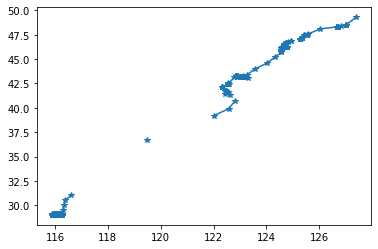

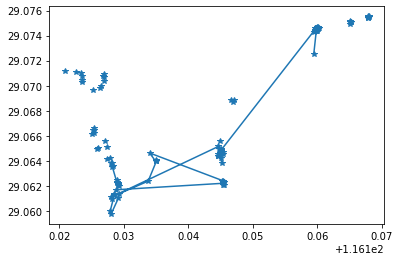

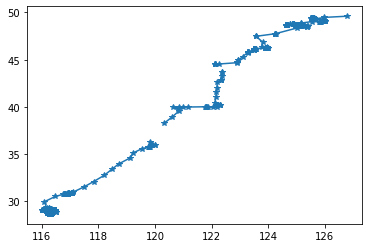

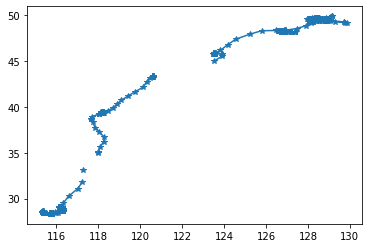

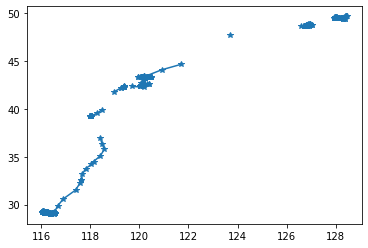

In [ ]:
for i_fig in [1,5,6,8,9]:
    plt.figure() 
    plt.plot(C_douyan[i_fig]['经度'],C_douyan[i_fig]['纬度'],'*-')
    plt.savefig('./鸟类轨迹/豆雁原始轨迹/Original_track'+str(i_fig)+'.png')
    (C_douyan[i_fig][['经度', '纬度']]).to_csv('./鸟类轨迹/豆雁原始轨迹/Original_track'+str(i_fig)+'.csv')

In [ ]:
C_douyan[i_fig][['经度', '纬度']]

经度        纬度
0     116.16788  29.07545
1     116.16791  29.07558
2     116.16794  29.07550
3     116.16793  29.07552
4     116.16792  29.07549
...         ...       ...
3023  128.29967  49.52903
3024  128.29993  49.52913
3025  128.30081  49.52947
3026  128.31105  49.53764
3027  128.31197  49.53803

[3028 rows x 2 columns]

In [ ]:
C = []
W = []
# C_baieyan = C_baieyan[[0:2,3:4,6]]
for i_bird in [1,5,6,8,9]:
    C_0 = C_douyan[i_bird][['经度','纬度','航向','高度','温度', '电压', '运动量', '卫星', 'HDOP', 'VDOP']].to_numpy()
    C_0[0,C_0[0,:]>180] = 180
    W_0 = np.zeros_like(C_0)
    W_0[(C_0 >= 0)] = 1 
    C_0 = pd.DataFrame(C_0).fillna(method = 'pad').to_numpy()
    C_0 = double_exponential_smoothing(C_0, alpha = 0.3, beta = 0.2)[1:,:]
    C_0 [C_0<0] = 0
    C.append(C_0)   # 预补全  VS   不预补全   *W_0 就是完全预补全
    W.append(W_0)

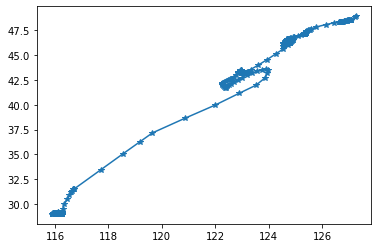

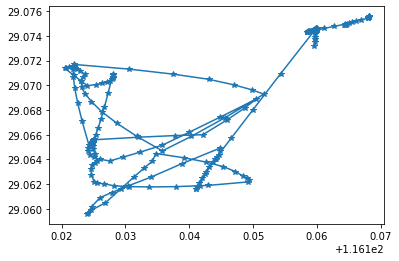

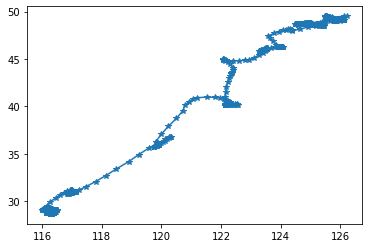

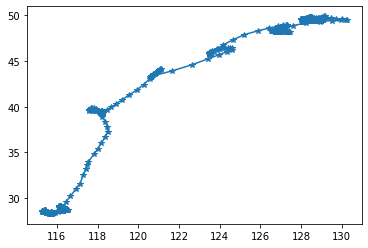

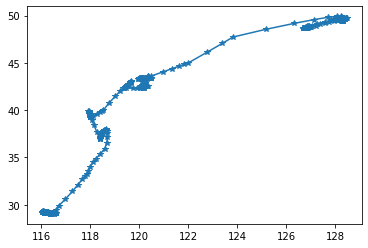

In [ ]:
str_ID = [1,5,6,8,9]
for i_fig in range(len(C)):
    plt.figure()
    plt.plot(C[i_fig][:,0],C[i_fig][:,1],'*-')
    np.savetxt('./鸟类轨迹/豆雁补全后轨迹/imputed_track'+str(str_ID[i_fig])+'.csv', [C[i_fig][:,0],C[i_fig][:,1]], delimiter=',')
    plt.savefig('./鸟类轨迹/豆雁补全后轨迹/imputed_track'+str(str_ID[i_fig])+'.png')

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
num_sum = 0
C_0 = sc_X.fit_transform(C[0])
C_all = C_0
W_all = W[0]
for i in range(len(C)-1):
    sc_X = StandardScaler()
    C_0 = sc_X.fit_transform(C[i+1])
    C_all = np.concatenate((C_all,C_0), 0)
    W_all = np.concatenate((W_all,W[i+1]), 0)

print(C_all.shape, W_all.shape)

(12225, 10) (12225, 10)


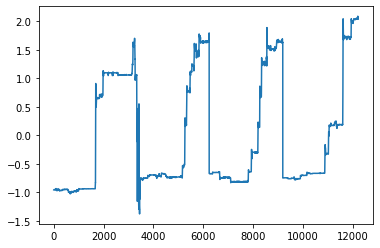

In [ ]:
plt.plot(C_all[:,0])

## 以后可以从这里开始，避免重复处理数据

In [ ]:
# sio.savemat('Birds.mat', {'C_all': C_all, 'W_all': W_all})

In [4]:
Birds_data = sio.loadmat('Birds.mat')

In [5]:
C_all = Birds_data['C_all']
W_all = Birds_data['W_all']
# C_all = C_all[:,4:6]
# W_all = W_all[:,4:6]

In [6]:

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#默认为范围0~1，拷贝操作
#min_max_scaler = preprocessing.MinMaxScaler(feature_range = (1,3),copy = False)#范围改为1~3，对原数组操作
Data_all_minmax = min_max_scaler.fit_transform(C_all)
MM = W_all
Data_all_minmax

array([[0.00967595, 0.00328082, 0.        , ..., 0.57047294, 0.05932129,
        0.11474164],
       [0.00967595, 0.00328082, 0.        , ..., 0.5252627 , 0.05389763,
        0.14276816],
       [0.00967595, 0.00328082, 0.        , ..., 0.52599737, 0.05093496,
        0.15061559],
       ...,
       [0.0096816 , 0.00329342, 0.        , ..., 0.56680461, 0.09488229,
        0.1896549 ],
       [0.00968161, 0.00329342, 0.        , ..., 0.53037804, 0.09644524,
        0.16466215],
       [0.00968161, 0.00329342, 0.        , ..., 0.53523557, 0.09596478,
        0.16214337]])

In [7]:
np.random.seed(0)
time_step=48
in_dim = C_all.shape[1]
batch_size  = 128
pre_horizon = 48
input_size=time_step
output_size=input_size
Z_size = 30
sample_num = C_all.shape[0]
EPOCH=10000
LR=1e-3
# start_cat = 0*11
# end_cat = 11*11
# num_cat = end_cat - start_cat
# # Prob_drop = 0.2

## 当前每隔1个时间步取一个样本，期望这样能让模型学习一定的知识

In [8]:
data=np.zeros((sample_num,time_step, in_dim),dtype=float)
data_C=np.zeros((sample_num,time_step, in_dim),dtype=float)
data_m=np.zeros((sample_num,time_step, in_dim),dtype=float)
# data_y=np.zeros((sample_num,pre_horizon, in_dim),dtype=float)

# for i in range(0,sample_num-time_step,time_step):
for i in range(0,sample_num-time_step-1,1):
    data[i,:,:]=Data_all_minmax[i:i+time_step,: ]
    data_C[i,:,:]=Data_all_minmax[i+1:i+time_step+1, : ]
    data_m[i,:,:] = MM[i:i+time_step,: ]


## 每隔48小时取一个样本

In [9]:
data=np.zeros((int(sample_num/time_step),time_step, in_dim),dtype=float)
data_C = np.zeros((int(sample_num/time_step),time_step, in_dim),dtype=float)
data_m=np.zeros((int(sample_num/time_step),time_step, in_dim),dtype=float)
# data_y=np.zeros((sample_num,pre_horizon, in_dim),dtype=float)

# for i in range(0,sample_num-time_step,time_step):
for i in range(0,sample_num-time_step-1,time_step):
    data[int(i/time_step),:,:] = Data_all_minmax[i:i + time_step,: ]
    data_C[int(i/time_step),:,:] = Data_all_minmax[i+1:i + time_step+1, : ]
    data_m[int(i/time_step),:,:] = MM[i:i+time_step,: ]


index = np.random.choice(np.arange(int(sample_num/time_step)), size=int(sample_num/time_step), replace=False)
data = data[index]
data_C = data_C[index]
data_m = data_m[index]

## 定义Data loader

In [20]:
data_train=torch.tensor(data,dtype=torch.float32)
data_C_train = torch.tensor(data_C, dtype = torch.float32)
data_m_train=torch.tensor(data_m,dtype=torch.float32)

data_train = data_train.permute(0,2,1)
data_C_train = data_C_train.permute(0,2,1)
data_m_train = data_m_train.permute(0,2,1)

print('data size: ',data_train.size())
print('data_C_train size: ',data_C_train.size())
print('data m size: ',data_m_train.size())

# XX_train = Data.TensorDataset(data_train[0:7000,:,:], data_C_train[0:7000,:,:], data_m_train[0:7000,:,:])
# XX_test = Data.TensorDataset(data_train[7000:,:,:], data_C_train[7000:,:,:], data_m_train[7000:,:,:])

XX_train = Data.TensorDataset(data_train[0:200,:,:], data_C_train[0:200,:,:], data_m_train[0:200,:,:])
# XX_train = Data.TensorDataset(data_train[0:140,:,:], data_m_train[0:140,:,:])
XX_test = Data.TensorDataset(data_train[200:,:,:], data_C_train[200:,:,:], data_m_train[200:,:,:])

XX_all = Data.TensorDataset(data_train, data_C_train, data_m_train)

# 把train dataset 放入 DataLoader
train_loader = Data.DataLoader(
    dataset=XX_all,      # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers = 0,
    pin_memory=True, 
)

# 把test dataset 放入 DataLoader
# XX = Data.TensorDataset(data,data_m)
test_loader = Data.DataLoader(
    dataset=XX_all,      # torch TensorDataset format
    batch_size = len(XX_test),      # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers = 0,
    pin_memory=True,
)

data size:  torch.Size([246, 10, 48])
data_C_train size:  torch.Size([246, 10, 48])
data m size:  torch.Size([246, 10, 48])


In [11]:
class AttentionLayer(nn.Module):
    """
    Attention Layer
    """

    def __init__(self, LSTM_dim, time_step = 48 ):
        super(AttentionLayer, self).__init__()
        self.LSTM_dim = LSTM_dim
        self.time_step = time_step
        self.Linear_atten = nn.Linear(self.LSTM_dim,self.time_step)
        self.soft = nn.Softmax()
        self.tanh = nn.Tanh()

    def forward(self,input):
        # a = input.permute(0,2,1)   # 把时间维度放在后面  b n t 
        # print('a',a.size())
        a = self.Linear_atten(input)  # b t t 
        a = self.tanh(a)  # b t t 
        a = self.soft(a)  # shape: b t t
        # print('a:',a.size(),'x:',input.size())
        x =  torch.matmul(a,input)  # b t t  *  b t n 
        return x 

In [12]:

class GAT_(nn.Module):
    def __init__(self, input_dim = 10):
        """Dense version of GAT."""
        super(GAT_, self).__init__()
        # self.dropout = dropout
        self.input_dim = input_dim
        self.LSTM_dim = 100
        # self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        # for i, attention in enumerate(self.attentions):
        #     self.add_module('attention_{}'.format(i), attention)

        # self.out_att = GraphAttentionLayer(nhid * nheads, nhid, dropout=dropout, alpha=alpha, concat=False)
        self.LSTM = nn.GRU(input_size=self.input_dim, hidden_size = self.LSTM_dim, batch_first = True) #, bidirectional  = True
        # self.Gcn = nn.Linear()

        # self.LSTM_DECAY = LSTM_decay(input_size = self.input_dim, output_size = self.input_dim)  
        self.BN0 = nn.BatchNorm1d(self.input_dim)
        self.BN2 = nn.BatchNorm1d((self.LSTM_dim)*48)  # 128*2+121
        self.dacay_att = AttentionLayer(self.LSTM_dim,48)

        self.lstm_att = AttentionLayer(self.LSTM_dim, 48) 
        self.reg1 = nn.Linear((self.LSTM_dim)*48, 512)
        self.reg2 = nn.Linear(512,512)
        self.reg3 = nn.Linear(512,512)
        self.reg4 = nn.Linear(512,self.input_dim*48)

        self.reg_lstm = nn.Linear(self.LSTM_dim,self.input_dim)
        self.reg_lstm_att = nn.Linear(self.LSTM_dim,self.input_dim)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)


    def forward(self, XX, G, M, eval_flag = 0):
        # print(XX.size(), M.size())
        # print('XX:',XX[0])
        # print('M:',M[0])
        # XX = (XX*M + (XX.sum(2)/((M).sum(2)+0.1)).unsqueeze(2).repeat(1,1,48)*(1-M))

        
        # print('X_in',X_in[0])
        # x = self.BN0(x)
        # out = torch.cat([att(X_in) for att in self.attentions], dim=2)
        # x = F.dropout(x, self.dropout, training=self.training)
        # out = self.out_att(out)
        # out = self.tanh(out)
        # out = out.permute(0,2,1)
        # M = M.permute(0,2,1)
        # out = self.drop(XX)
        out = G.matmul(XX)
        out = out + XX 
        out = out.permute(0,2,1)
        # LSTM decay + Attention 
        # h_decay = self.LSTM_DECAY(out, M)   # batchsize 48, 121
        # h_decay = self.dacay_att(h_decay)         # decay和attention不能一起用

        h_lstm,_ = self.LSTM(out)
        out_1 = self.reg_lstm(h_lstm).permute(0,2,1)

        h_lstm_att = self.lstm_att(h_lstm)
        out_2 = self.reg_lstm(h_lstm_att).permute(0,2,1)
        # h_lstm = 
        # out = torch.cat((h_decay,h_lstm), dim = 2)
        # out = h_decay
        # out = out.contiguous()
        # out = out.view(out.size(0),-1)
        # out = out_1 + out_2
        # out = out.permute(0,2,1)
        # out = self.BN2(out)

        # print(h.size())
        # out = self.reg1(out)
        # out = self.relu(out)
        # out = self.reg2(out)
        # out = self.relu(out)
        # # out = self.drop(out)
        # out = self.reg3(out)
        # out = self.relu(out)
        # out = self.reg4(out)
        # out = out.view(-1,self.input_dim,48)

        # x = x.view(T, N, -1)  # (7580, 228, 3)
        return out_1 # + XX

## 定义整体模型

In [13]:
class Overall_model(nn.Module):
    def __init__(self, Causal_model, Imputation_model):
        super(Overall_model, self).__init__()
        self.Causal = Causal_model
        self.Imputatation = Imputation_model

    def forward(self, XX, M):
        # print(XX.size, M.size())
        # 数据处理，对缺失值使用padding填充
        XX_numpy = XX.cpu().detach().numpy()
        M_nan = (1-M.cpu().detach().numpy()).astype(bool)
        XX_numpy[M_nan] = np.nan
        # # print(XX_numpy)
        XX_numpy = [pd.DataFrame(XX_numpy[i].T).fillna(method = 'pad').to_numpy() for i in range(XX_numpy.shape[0])]
        XX_numpy = np.array(XX_numpy)
        XX_numpy = [pd.DataFrame(XX_numpy[i]).fillna(0.5).to_numpy() for i in range(XX_numpy.shape[0])]
        XX_numpy = torch.Tensor(XX_numpy).to(device)
        XX_numpy = XX_numpy.permute(0,2,1)
        # XX_numpy = double_exponential_smoothing(XX_numpy, alpha = 0.3, beta = 0.2)[1:,:]      

        XX = XX.permute(0,2,1)
        pred = [self.Causal.networks[i](XX)[0] for i in range(XX.size(2))]
        GC_est = self.Causal.GC(threshold = False)

        W_est = GC_est
        D = W_est.sum(1)
        D_12 = torch.diag(D**(-0.5))
        Graph_L = D_12.mm(torch.diag(D)-W_est).mm(D_12)

        XX = XX.permute(0,2,1)
        # XX = XX*M
        re_x = self.Imputatation(XX, Graph_L, M)
        return re_x, pred

In [17]:
def overall_loss(y_pred, Y, re_x, X, M, sparsity_loss, w_1 = 1000, w_2 = 3, w_3 = 0.03, w_4 = 0.1):  # w_1 = 100, w_2 = 3, w_3 = 0.03, w_4 = 0.1
    imputa_loss = F.mse_loss(re_x*M, X*M) 
    smooth_loss = F.l1_loss(re_x[:,:,1:] , re_x[:,:,:-1])
    pred_loss = sum([F.mse_loss(y_pred[i][:, :, 0], Y[:, :, i]) for i in range(Y.size(2))])

    return w_1*imputa_loss +  w_2*smooth_loss + w_3*pred_loss + w_4*sparsity_loss 

In [18]:
i_Prob_drop = 0.1
Train_Loss = []
Test_Loss = []

for w2 in [3]:
    GCN_LSTM = GAT_(input_dim= in_dim ).to(device)
    clstm = cLSTM(in_dim, hidden=100).to(device)
    model = Overall_model(Causal_model = clstm, Imputation_model = GCN_LSTM).to(device)
    # model = 
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay= 0.001)
    for epoch in range(300):
            model.train() 
            for step, (XX,YY,M) in enumerate(train_loader):  
                Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                Mask_matrix = torch.Tensor((Temp_mask>i_Prob_drop) + 0.0).to(device)
                XX = XX.to(device)
                YY = YY.to(device)
                M = M.to(device)
                XX_in = (XX*M*Mask_matrix).to(device)
                re_x, y_pred= model(XX_in, Mask_matrix) 
                # re_x = model(XX, M*Mask_matrix) 
                sparse_loss = sum([regularize(net, 0.01) for net in clstm.networks]) + sum([ridge_regularize(net, 0.01) for net in clstm.networks])

                loss = overall_loss(y_pred, YY.permute(0,2,1), re_x, XX, M, sparse_loss, w_2 = w2)    # 这里的M不应该乘Mask_matrix
                # loss = F.mse_loss(re_x, XX) 
                loss.backward()                         # backpropagation, compute gradients
                optimizer.step()
                optimizer.zero_grad()                   # clear gradients for this training step
                Train_Loss.append(loss.cpu().detach().numpy())
        # print('Epoch =' , epoch, 'Traing loss = ',loss)

            if epoch%10 == 0:
            # with torch.no_grad():
                model.eval()
                for (XX, YY, M) in test_loader:
                    Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                    Mask_matrix = torch.Tensor((Temp_mask>i_Prob_drop) + 0.0).to(device)
                    XX = XX.to(device)
                    YY = YY.to(device)
                    M = M.to(device)
                    XX_in = (XX*M*Mask_matrix).to(device)

                    re_x, _= model(XX_in, M*Mask_matrix)

                    MSE_loss = (F.mse_loss(re_x*(1-Mask_matrix)*M, XX*(1-Mask_matrix)*M) /(i_Prob_drop)).cpu().detach().numpy()
                    RMSE_loss = (MSE_loss)**(0.5)
                    MAE_loss = (torch.sum(torch.abs((re_x-XX)*(1-Mask_matrix)*M) )/ ((1-Mask_matrix).sum())).cpu().detach().numpy().item()
                
                Test_Loss.append(MSE_loss)
                print("i_Prob_drop:{:.4f}, Epoch:{}, |recon_loss:{:.4f}, |Imput MSE:{:.3f}, |Imput RMSE:{:.5f}, |Imput MAE:{:.5f}".format(i_Prob_drop, epoch, loss.cpu().detach().numpy().item(), MSE_loss.item(), RMSE_loss, MAE_loss ) ) 

i_Prob_drop:0.1000, Epoch:0, |recon_loss:28.1794, |Imput MSE:0.024, |Imput RMSE:0.15554, |Imput MAE:0.10417
i_Prob_drop:0.1000, Epoch:10, |recon_loss:3.8042, |Imput MSE:0.009, |Imput RMSE:0.09332, |Imput MAE:0.05839
i_Prob_drop:0.1000, Epoch:20, |recon_loss:2.7642, |Imput MSE:0.008, |Imput RMSE:0.09216, |Imput MAE:0.05646
i_Prob_drop:0.1000, Epoch:30, |recon_loss:2.2865, |Imput MSE:0.008, |Imput RMSE:0.08708, |Imput MAE:0.05030
i_Prob_drop:0.1000, Epoch:40, |recon_loss:2.0223, |Imput MSE:0.006, |Imput RMSE:0.07985, |Imput MAE:0.04803
i_Prob_drop:0.1000, Epoch:50, |recon_loss:1.7343, |Imput MSE:0.009, |Imput RMSE:0.09581, |Imput MAE:0.05261
i_Prob_drop:0.1000, Epoch:60, |recon_loss:1.4528, |Imput MSE:0.005, |Imput RMSE:0.06940, |Imput MAE:0.03715
i_Prob_drop:0.1000, Epoch:70, |recon_loss:1.2559, |Imput MSE:0.004, |Imput RMSE:0.06388, |Imput MAE:0.03483
i_Prob_drop:0.1000, Epoch:80, |recon_loss:1.0398, |Imput MSE:0.005, |Imput RMSE:0.06789, |Imput MAE:0.03486
i_Prob_drop:0.1000, Epoch:90

## 绘制训练及测试误差曲线

In [ ]:
plt.figure()
plt.plot(Train_Loss)
plt.figure()
plt.plot(Test_Loss)

In [21]:
        for drop_prob in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
        # for drop_prob in [0.3]:
            with torch.no_grad():
                model.eval()
                for (XX,YY, M) in test_loader:
                    Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                    Mask_matrix = torch.Tensor((Temp_mask > drop_prob) + 0.0)
                    XX_in = XX *M*Mask_matrix
                    XX_in = XX_in.to(device)
                    XX = XX.to(device)
                    M = M.to(device) 
                    Mask_matrix = Mask_matrix.to(device)
                    # mu,lnvar,re_x,D_fake,log_det = model(torch.zeros_like(XX_in).to(device),eval_flag = 1)
                    # mu,lnvar,re_x,D_fake,log_det = model(torch.rand_like(XX_in),eval_flag = 1)                    
                    re_x,_ = model(XX_in, M*Mask_matrix)
                    MSE_loss = (F.mse_loss(re_x*(1-Mask_matrix)*M, XX*(1-Mask_matrix)*M) /(drop_prob)).cpu().detach().numpy() 
                    RMSE_loss = (MSE_loss)**(0.5)
                    MAE_loss = (torch.sum(torch.abs((re_x-XX)*(1-Mask_matrix)*M) )/  ((1-Mask_matrix).sum())).cpu().detach().numpy().item()
                    print('drop rate',drop_prob,'MSE loss', MSE_loss, 'RMSE loss', RMSE_loss, 'MAE loss', MAE_loss)

drop rate 0.1 MSE loss 0.0017710436 RMSE loss 0.04208377 MAE loss 0.022205326706171036
drop rate 0.1 MSE loss 0.0018747547 RMSE loss 0.04329844 MAE loss 0.022177323698997498
drop rate 0.1 MSE loss 0.0018356957 RMSE loss 0.04284502 MAE loss 0.022776056081056595
drop rate 0.1 MSE loss 0.0016029184 RMSE loss 0.040036462 MAE loss 0.021904518827795982
drop rate 0.1 MSE loss 0.0020736575 RMSE loss 0.04553743 MAE loss 0.023602910339832306
drop rate 0.1 MSE loss 0.0023092923 RMSE loss 0.048055097 MAE loss 0.025218140333890915
drop rate 0.2 MSE loss 0.0026395847 RMSE loss 0.05137689 MAE loss 0.025964077562093735
drop rate 0.2 MSE loss 0.0029911217 RMSE loss 0.054691147 MAE loss 0.026340464130043983
drop rate 0.2 MSE loss 0.002815866 RMSE loss 0.053064734 MAE loss 0.02699010819196701
drop rate 0.2 MSE loss 0.0026240912 RMSE loss 0.051225886 MAE loss 0.02700897492468357
drop rate 0.2 MSE loss 0.003127994 RMSE loss 0.055928472 MAE loss 0.02798526920378208
drop rate 0.2 MSE loss 0.0034433578 RMSE l

In [ ]:
        for drop_prob in [0.2]:
            with torch.no_grad():
                model.eval()
                for (XX,YY, M) in test_loader:
                    Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                    Mask_matrix = torch.Tensor((Temp_mask > drop_prob) + 0.0)
                    XX_in = XX *M*Mask_matrix
                    XX_in = XX_in.to(device)
                    XX = XX.to(device)
                    M = M.to(device) 
                    Mask_matrix = Mask_matrix.to(device)
                    re_x,_ = model(XX_in, M*Mask_matrix)
                    MSE_loss = (F.mse_loss(re_x*(1-Mask_matrix)*M, XX*(1-Mask_matrix)*M) /(drop_prob)).cpu().detach().numpy() 
                    RMSE_loss = (MSE_loss)**(0.5)
                    MAE_loss = (torch.sum(torch.abs((re_x-XX)*(1-Mask_matrix)*M) )/  ((1-Mask_matrix).sum())).cpu().detach().numpy().item()
                    print('drop rate',drop_prob,'MSE loss', MSE_loss, 'RMSE loss', RMSE_loss, 'MAE loss', MAE_loss) 
                    break

drop rate 0.2 MSE loss 0.004303101 RMSE loss 0.065598026 MAE loss 0.03683583438396454


In [ ]:
X_pred = XX_in + re_x * (1- M*Mask_matrix)

XX = XX.cpu().detach().numpy()
XX_in = XX_in.cpu().detach().numpy()
re_x = re_x.cpu().detach().numpy()
X_pred = X_pred.cpu().detach().numpy()
M = M.cpu().detach().numpy()
Mask_matrix = Mask_matrix.cpu().detach().numpy()
M_nan = M*Mask_matrix
M_nan[M_nan==0] = np.nan

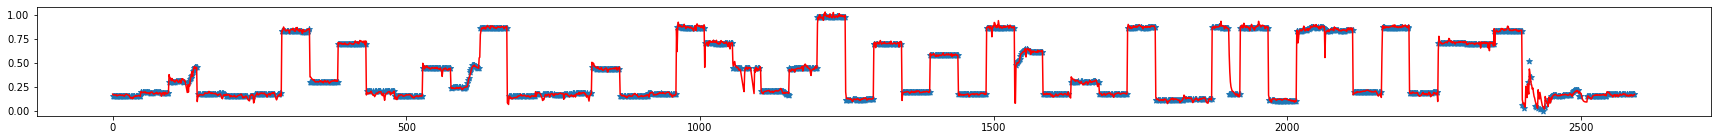

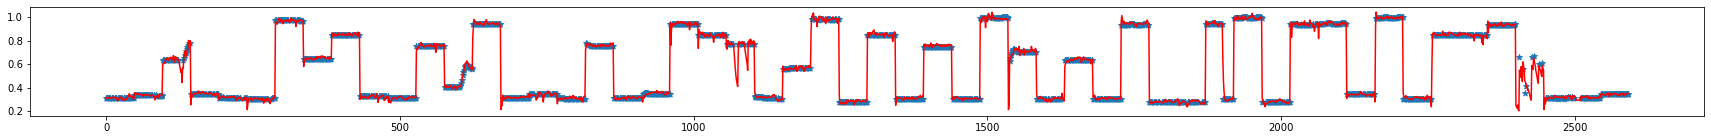

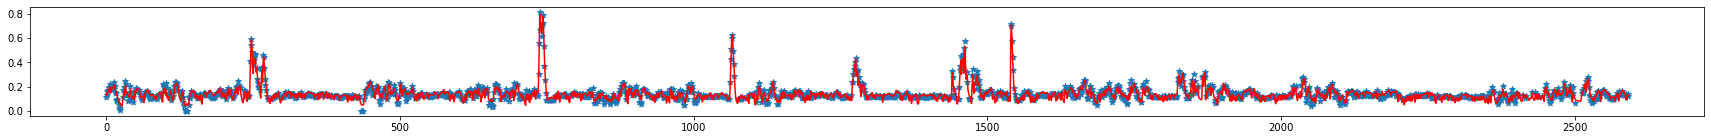

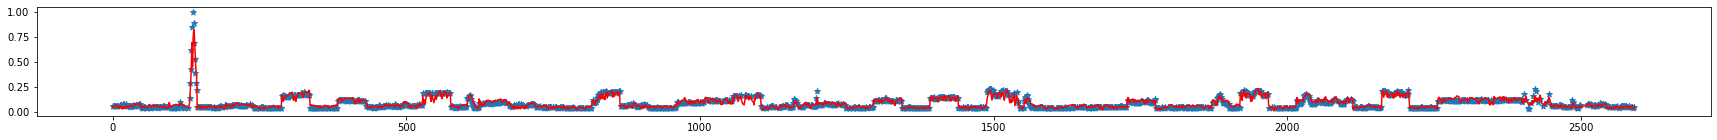

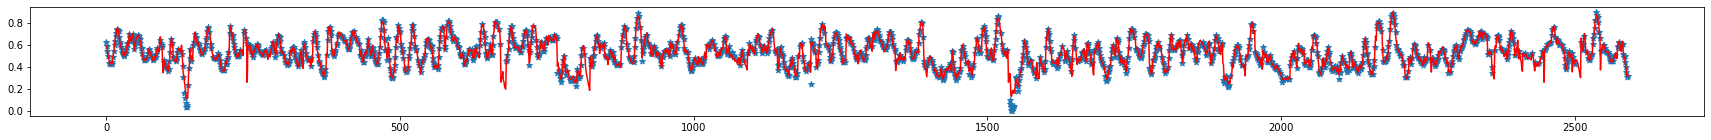

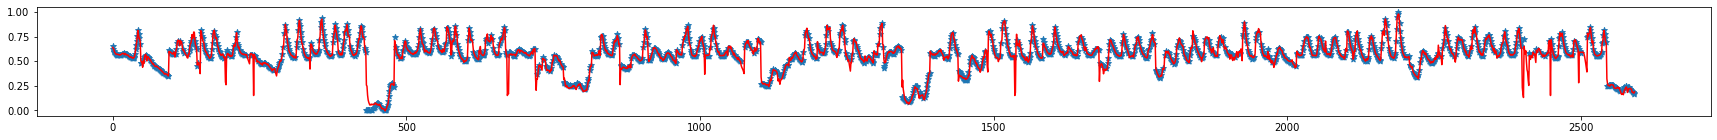

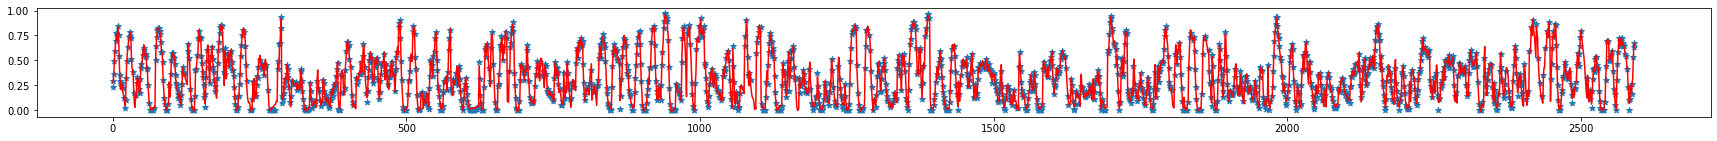

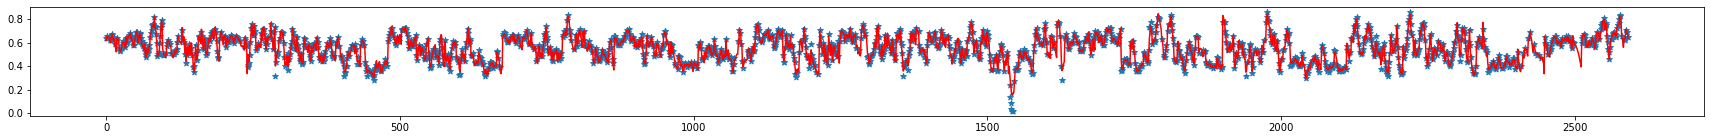

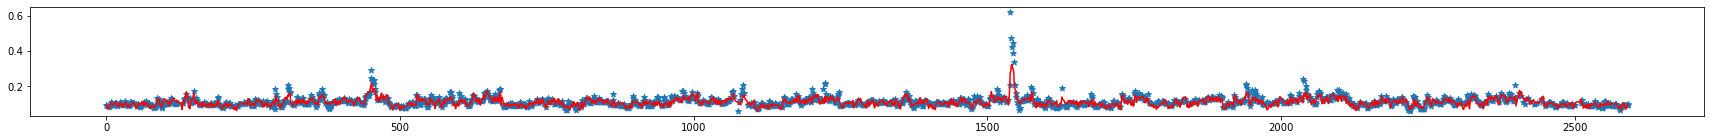

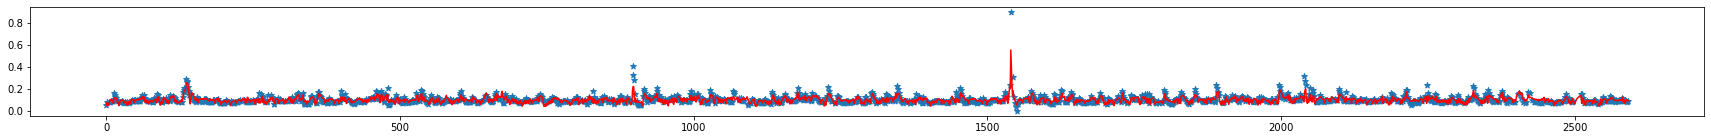

In [ ]:
plot_len = 5000
for i_plot_char in range(XX.shape[1]):
    plot_char = i_plot_char

    # plot_temp = [XX[i,plot_char,:] for  i in range(XX.shape[0])]
    # plot_temp = np.array(plot_temp).reshape(-1)
    # plot_temp = plot_temp[0:plot_len]
    # plt.figure(figsize=(30,2))
    # plt.plot(range(plot_temp.shape[0]), plot_temp, marker='*')

    plot_temp = [(XX_in*M_nan)[i,plot_char,:] for  i in range(XX_in.shape[0])]
    plot_temp = np.array(plot_temp).reshape(-1)
    plot_temp = plot_temp[0:plot_len]
    plt.figure(figsize=(30,2))
    plt.scatter(range(plot_temp.shape[0]), plot_temp, marker='*')

    plot_temp = [re_x[i,plot_char,:] for  i in range(re_x.shape[0])]
    plot_temp = np.array(plot_temp).reshape(-1)
    plot_temp = plot_temp[0:plot_len]
    # plt.figure(figsize=(30,2))
    plt.plot(range(plot_temp.shape[0]), plot_temp, 'r')  #,marker='*'

In [23]:
clstm.GC(threshold = False) 

tensor([[0.0900, 0.0581, 0.1672, 0.1519, 0.1441, 0.3590, 0.4520, 0.9058, 0.2754,
         0.0492],
        [0.1111, 0.1554, 0.2556, 0.0849, 0.1075, 1.0556, 0.2208, 0.2046, 0.1279,
         0.0791],
        [0.1256, 0.1443, 0.0290, 0.1307, 0.1663, 0.1858, 0.1196, 0.1257, 0.0717,
         0.2640],
        [0.1995, 0.1767, 0.0521, 0.0200, 0.4473, 0.2814, 0.2119, 0.1635, 0.1666,
         0.0627],
        [0.2523, 0.2736, 0.1714, 0.0801, 0.0422, 0.9234, 0.1069, 0.2882, 0.2409,
         0.0459],
        [0.3147, 0.3274, 0.1328, 0.1760, 0.1137, 0.0511, 0.2344, 0.7075, 0.2198,
         0.0873],
        [0.1538, 0.1427, 0.0708, 0.0604, 0.2518, 0.0916, 0.0568, 0.6051, 0.1063,
         0.0811],
        [0.3469, 0.3378, 0.1705, 0.1209, 0.2191, 0.5670, 0.1019, 0.0991, 0.0666,
         0.1545],
        [0.0446, 0.0592, 0.0523, 0.0830, 0.2492, 0.5169, 0.0539, 1.6881, 0.0523,
         0.0428],
        [0.1119, 0.0747, 0.0880, 0.1428, 0.6068, 0.1128, 0.1356, 0.0720, 0.0627,
         0.0431]], device='c

In [34]:
GC_est = clstm.GC(threshold = False).cpu().data.numpy()
# GC_est[GC_est<0.1] = 0
GC_est[GC_est>0.1] = 1

plt.figure(figsize=(10, 10))
plt.ylabel('Affected series', fontsize = 20)
plt.xlabel('Causal series', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# plt.imshow(GC_est, cmap='Blues', vmin=0, vmax=2, extent=(0, len(GC_est), len(GC_est), 0))
plt.imshow(GC_est, cmap='Blues')

plt.show()
plt.savefig('./saved_fig/Causal_Kdd.jpg', bbox_inches = 'tight')

In [ ]:
import torch 
from torch.autograd import Variable
import torch.autograd

In [ ]:
v = Variable(torch.Tensor([1, 2, 3]), requires_grad=True)
p = Variable(torch.Tensor([2, 3, 4]), requires_grad=True)
# h = v.register_hook(lambda grad: grad * 2)  # double the gradient
h = v.matmul(p.T)
h.backward()
#先计算原始梯度，再进hook，获得一个新梯度。
# print(h.grad)

In [ ]:
v.grad

tensor([2., 3., 4.])

In [ ]:
class net_f_uv(nn.Module):

    def __init__(self):
        super(net_f_uv, self).__init__()
        self.net_uv = nn.Linear(2,4,bias = False)
    def forward(self,x,t):
        X_in = Variable(torch.cat((x, t), 0),requires_grad=True)   # torch.cat((x, t), 0)
        out = self.net_uv(X_in)
        u, v, u_x, v_x  = out[0], out[1], out[2], out[3]
        u_t = autograd.grad(outputs= u, inputs=X_in,retain_graph = True) [0] [1]   #X_in.grad[1]
        # print(autograd.grad(outputs= u, inputs=X_in))
        v_t = autograd.grad(outputs= v, inputs=X_in,retain_graph = True) [0] [1]
        # print('v = ', v, 'v_t = ', v_t)
        u_xx = autograd.grad(outputs= u_x, inputs=X_in,retain_graph = True) [0] [0]
        v_xx = autograd.grad(outputs= v_x, inputs=X_in,retain_graph = True) [0] [0]
        return u_t, v_t, u_xx, v_xx

In [ ]:
Net = net_f_uv()

In [ ]:
x = Variable(torch.Tensor([1]), requires_grad=True)
t = Variable(torch.Tensor([1]), requires_grad=True)
a,b,c,d = Net(x,t)

In [ ]:
Net.net_uv.weight

Parameter containing:
tensor([[-0.2919,  0.5423],
        [-0.0568, -0.3807],
        [ 0.1771, -0.3365],
        [-0.6274, -0.3573]], requires_grad=True)

In [ ]:
print(a,b,c,d)

tensor(0.5423) tensor(-0.3807) tensor(0.1771) tensor(-0.6274)
